# Stock Price Prediction

## LSTM

In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

In [19]:
train_csv = './data/Stock_data/AMZNtrain.csv'
data = pd.read_csv(train_csv)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,398.799988,399.359985,394.019989,397.970001,397.970001,2137800
1,2014-01-03,398.290009,402.709991,396.220001,396.440002,396.440002,2210200
2,2014-01-06,395.850006,397.000000,388.420013,393.630005,393.630005,3170600
3,2014-01-07,395.040009,398.470001,394.290009,398.029999,398.029999,1916000
4,2014-01-08,398.470001,403.000000,396.040009,401.920013,401.920013,2316500


In [20]:
from sklearn.preprocessing import MinMaxScaler

price = data[['Close']]
scaler = MinMaxScaler(feature_range=(-1,1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [21]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [22]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)


In [23]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [24]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [25]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [26]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.7154965996742249
Epoch  1 MSE:  0.5123347640037537
Epoch  2 MSE:  0.34916040301322937
Epoch  3 MSE:  0.19013987481594086
Epoch  4 MSE:  0.06953302025794983
Epoch  5 MSE:  0.22544020414352417
Epoch  6 MSE:  0.1435738354921341
Epoch  7 MSE:  0.07466008514165878
Epoch  8 MSE:  0.0720399022102356
Epoch  9 MSE:  0.0908813625574112
Epoch  10 MSE:  0.10460980236530304
Epoch  11 MSE:  0.10760724544525146
Epoch  12 MSE:  0.10192123055458069
Epoch  13 MSE:  0.09135689586400986
Epoch  14 MSE:  0.07971961051225662
Epoch  15 MSE:  0.07024820894002914
Epoch  16 MSE:  0.06514051556587219
Epoch  17 MSE:  0.06501077860593796
Epoch  18 MSE:  0.06844452768564224
Epoch  19 MSE:  0.07225343585014343
Epoch  20 MSE:  0.07311322540044785
Epoch  21 MSE:  0.06979838758707047
Epoch  22 MSE:  0.06367282569408417
Epoch  23 MSE:  0.05713610723614693
Epoch  24 MSE:  0.05197601020336151
Epoch  25 MSE:  0.04873437061905861
Epoch  26 MSE:  0.04670121893286705
Epoch  27 MSE:  0.04413928464055061
Epoch  

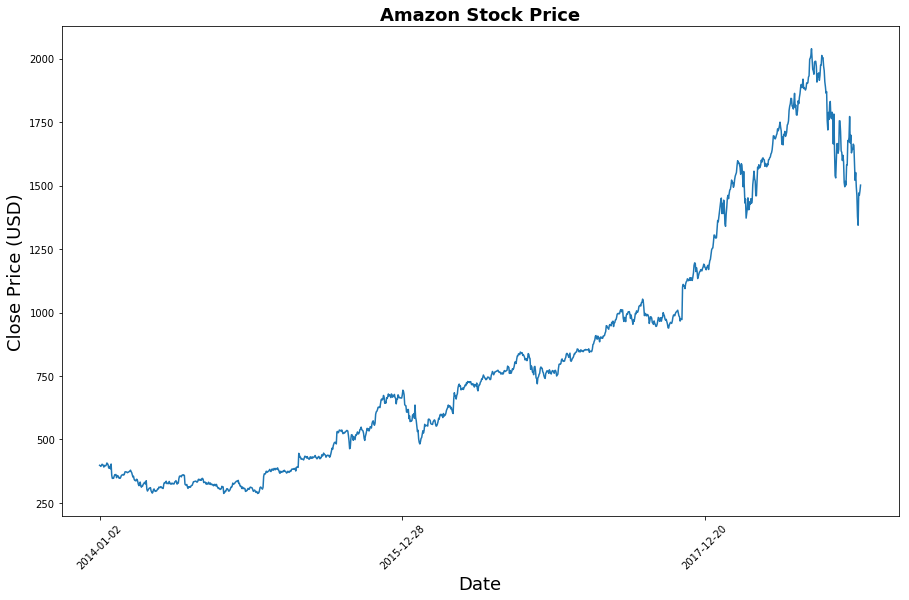

In [27]:
import matplotlib.pyplot as plt
#import seaborn as sns

#sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("Amazon Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

## GRUs

In [37]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRU, self ).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        #GRU layers
        self.gru = nn.GRU(input_dim, hidden_dim,  num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        out, (hn)= self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [38]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [39]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_gru)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.632594883441925
Epoch  1 MSE:  0.2188560962677002
Epoch  2 MSE:  0.05649227648973465
Epoch  3 MSE:  0.21306897699832916
Epoch  4 MSE:  0.11276254057884216
Epoch  5 MSE:  0.04903034493327141
Epoch  6 MSE:  0.06877673417329788
Epoch  7 MSE:  0.09675970673561096
Epoch  8 MSE:  0.0976032018661499
Epoch  9 MSE:  0.07569441944360733
Epoch  10 MSE:  0.04708397388458252
Epoch  11 MSE:  0.02848992496728897
Epoch  12 MSE:  0.02969305031001568
Epoch  13 MSE:  0.04310831055045128
Epoch  14 MSE:  0.04677615314722061
Epoch  15 MSE:  0.03337940201163292
Epoch  16 MSE:  0.016875090077519417
Epoch  17 MSE:  0.010500084608793259
Epoch  18 MSE:  0.014627877622842789
Epoch  19 MSE:  0.02066650427877903
Epoch  20 MSE:  0.020343594253063202
Epoch  21 MSE:  0.012387304566800594
Epoch  22 MSE:  0.003149976022541523
Epoch  23 MSE:  0.0013004466891288757
Epoch  24 MSE:  0.007943131029605865
Epoch  25 MSE:  0.012436319142580032
Epoch  26 MSE:  0.00817637238651514
Epoch  27 MSE:  0.00251793046481